# MotionML
### *Motion pattern recognition using KNN-DTW and classifiers from TinyLearn*

This is a domain-specific example of using TinyLearn module for recognizing (classifying) the motion patterns according to the supplied accelerometer data. 

The following motion patterns are included into this demo:

* Walking
* Sitting down on a chair
* Getting up from a bed
* Drinking a glass
* Descending stairs
* Combing hair
* Brushing teeth

The accelerometer data is based on the following public dataset from UCI: [Dataset for ADL Recognition with Wrist-worn Accelerometer](https://archive.ics.uci.edu/ml/datasets/Dataset+for+ADL+Recognition+with+Wrist-worn+Accelerometer) 

This IP[y] Notebook performs a step-by-step execution of *'motion_rec_demo.py'* file with extra comments. The source code is available on [GitHub](https://github.com/llvll/motionml)

Dynamic Time Warping (DTW) and K-Nearest Neighbors (KNN) algorithms for machine learning are used to demonstrate labeling of the varying-length sequences with accelerometer data. Such algorithms can be applied to time series classification or other cases, which require matching / training sequences with unequal lengths.

Scikit-Learn doesn't have any DTW implementations, so a custom class has been implemented (KnnDtwClassifier) as a part of TinyLearn module.

DTW is slow by default, taking into account its quadratic complexity, that's why we're speeding up the classification using an alternative approach with histograms and CommonClassifier from TinyLearn.

Let's start exploring the demo script ...

In the beginning we're loading the accelerometer data from TXT files:

In [2]:
from tinylearn import KnnDtwClassifier
from tinylearn import CommonClassifier
import pandas as pd
import numpy as np
import os

train_labels = []
test_labels = []
train_data_raw = []
train_data_hist = []
test_data_raw = []
test_data_hist = []

# Utility function for normalizing numpy arrays
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0:
        return v
    return v / norm

# Loading all data for training and testing from TXT files
def load_data():
    for d in os.listdir("data"):
        for f in os.listdir(os.path.join("data", d)):
            if f.startswith("TRAIN"):
                train_labels.append(d)
                tr = normalize(np.ravel(pd.read_csv(os.path.join("data", d, f),
                                                    delim_whitespace=True,
                                                    header=None)))
                train_data_raw.append(tr)
                train_data_hist.append(np.histogram(tr, bins=20)[0])
            else:
                test_labels.append(d)
                td = normalize(np.ravel(pd.read_csv(os.path.join("data", d, f),
                                                delim_whitespace=True,
                                                header=None)))
                test_data_raw.append(td)
                test_data_hist.append(np.histogram(td, bins=20)[0])

In [3]:
load_data()

Let's plot several selected histograms for the train data:

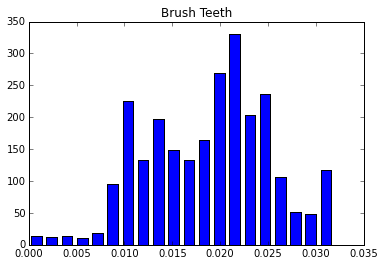

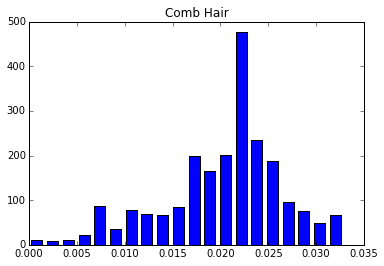

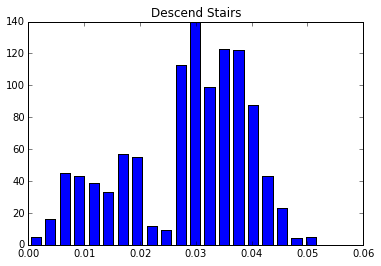

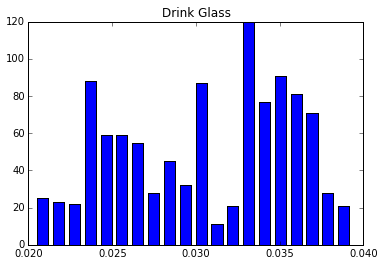

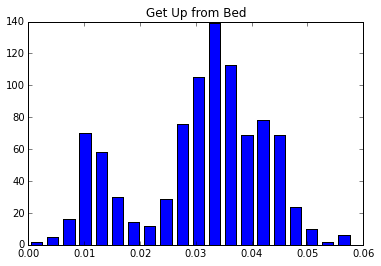

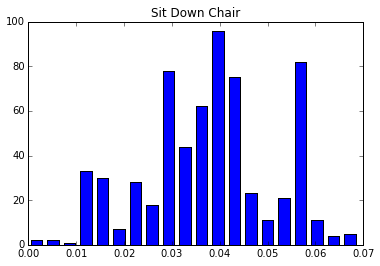

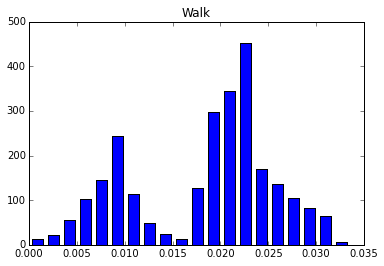

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

for i in range (0, 35, 5):
    hist, bins = np.histogram(train_data_raw[i], bins=20)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.title(train_labels[i])
    plt.bar(center, hist, align='center', width=width)
    plt.show()    

Before we will explore the classification with histograms let's try the default approach using KNN-DTW:

In [26]:
# Raw sequence labeling with KnnDtwClassifier and KNN=1
clf1 = KnnDtwClassifier(1)
clf1.fit(train_data_raw, train_labels)

for index, t in enumerate(test_data_raw):
    print("KnnDtwClassifier prediction for " + 
          str(test_labels[index]) + " = " + str(clf1.predict(t)))

KnnDtwClassifier prediction for Brush Teeth = ['Brush Teeth']
KnnDtwClassifier prediction for Comb Hair = ['Comb Hair']
KnnDtwClassifier prediction for Descend Stairs = ['Descend Stairs']
KnnDtwClassifier prediction for Drink Glass = ['Drink Glass']
KnnDtwClassifier prediction for Get Up from Bed = ['Get Up from Bed']
KnnDtwClassifier prediction for Sit Down Chair = ['Sit Down Chair']
KnnDtwClassifier prediction for Walk = ['Walk']


Bingo! All classifications are correct! Though it took some time for executing KNN-DTW classification ... Let's go deeper into the details of KNN-DTW for our accelerometer data and use KNN=3 with distance information. This time we will measure the performance as well.

In [47]:
# Let's do an extended prediction to get the distances to 3 nearest neighbors
clf2 = KnnDtwClassifier(3)
clf2.fit(train_data_raw, train_labels)

def classify2():
    for index, t in enumerate(test_data_raw):
        res = clf2.predict_ext(t)
        nghs = np.array(train_labels)[res[1]]
        print("KnnDtwClassifier neighbors for " + str(test_labels[index]) + " = " + str(nghs))
        print("KnnDtwClassifier distances to " + str(nghs) + " = " + str(res[0]))

%time classify2()

KnnDtwClassifier neighbors for Brush Teeth = ['Brush Teeth' 'Brush Teeth' 'Brush Teeth']
KnnDtwClassifier distances to ['Brush Teeth' 'Brush Teeth' 'Brush Teeth'] = [ 23.8696584   25.24900672  25.26283176]
KnnDtwClassifier neighbors for Comb Hair = ['Comb Hair' 'Brush Teeth' 'Comb Hair']
KnnDtwClassifier distances to ['Comb Hair' 'Brush Teeth' 'Comb Hair'] = [ 12.95719375  12.98959534  13.3247963 ]
KnnDtwClassifier neighbors for Descend Stairs = ['Descend Stairs' 'Drink Glass' 'Drink Glass']
KnnDtwClassifier distances to ['Descend Stairs' 'Drink Glass' 'Drink Glass'] = [ 3.89124356  7.04213924  7.4373459 ]
KnnDtwClassifier neighbors for Drink Glass = ['Drink Glass' 'Drink Glass' 'Drink Glass']
KnnDtwClassifier distances to ['Drink Glass' 'Drink Glass' 'Drink Glass'] = [ 5.26797232  6.57859269  7.04353381]
KnnDtwClassifier neighbors for Get Up from Bed = ['Get Up from Bed' 'Drink Glass' 'Drink Glass']
KnnDtwClassifier distances to ['Get Up from Bed' 'Drink Glass' 'Drink Glass'] = [ 6.01

All results are correct as well! But the executime time is not the best one - almost 1 min 30 seconds ... So let's try to use a faster alternative for classification, which doesn't depend upon DTW and its execution time:

In [48]:
# Let's use CommonClassifier with the histogram data for faster prediction
clf3 = CommonClassifier(default=True)
clf3.fit(train_data_hist, train_labels)

clf3.print_fit_summary()
print("\n")

def classify3():
    for index, t in enumerate(test_data_hist):
        print("CommonClassifier prediction for " + str(test_labels[index]) + " = " 
                + str(clf3.predict(t)))

%time classify3()

Selection summary based on GridSearchCV and 5 estimators.
Selected estimator 'ExtraTreeClassifier' with 0.714285714286 mean score.
ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

Other scores ...
Estimator 'LogisticRegression' has mean score 0.514285714286
Estimator 'RandomForestClassifier' has mean score 0.628571428571
Estimator 'SVC' has mean score 0.714285714286
Estimator 'SGDClassifier' has mean score 0.542857142857


CommonClassifier prediction for Brush Teeth = ['Brush Teeth']
CommonClassifier prediction for Comb Hair = ['Comb Hair']
CommonClassifier prediction for Descend Stairs = ['Descend Stairs']
CommonClassifier prediction for Drink Glass = ['Drink Glass']
CommonClassifier prediction for

19.1 ms for the total execution - much better!

We're done with this demo script. Adding the source code for KnnDtwClassifier and CommonClassifier to clarify the implementation details. 

In [ ]:
class KnnDtwClassifier(BaseEstimator, ClassifierMixin):
    """Custom classifier implementation for Scikit-Learn using Dynamic Time Warping (DTW)
       and KNN (K-Nearest Neighbors) algorithms.
       This classifier can be used for labeling the varying-length sequences, like time series
       or motion data.
       FastDTW library is used for faster DTW calculations - linear instead of quadratic complexity.
    """
    def __init__(self, n_neighbors=1):
        self.n_neighbors = n_neighbors
        self.features = []
        self.labels = []

    def get_distance(self, x, y):
        return fastdtw(x, y)[0]

    def fit(self, X, y=None):
        for index, l in enumerate(y):
            self.features.append(X[index])
            self.labels.append(l)
        return self

    def predict(self, X):
        dist = np.array([self.get_distance(X, seq) for seq in self.features])
        indices = dist.argsort()[:self.n_neighbors]
        return np.array(self.labels)[indices]

    def predict_ext(self, X):
        dist = np.array([self.get_distance(X, seq) for seq in self.features])
        indices = dist.argsort()[:self.n_neighbors]
        return (dist[indices],
                indices)


class CommonClassifier(object):
    """Helper class to execute the common classification workflow - from training to prediction
       to metrics reporting with the popular ML algorithms, like SVM or Random Forest.
       Includes the default list of estimators with instances and parameters, which have been
       proven to work well.
    """
    def __init__(self, default=True, cv=5, reduce_func=None):
        self.cv = cv
        self.default = default
        self.reduce_func = reduce_func
        self.reducer = None
        self.grid_search = None

    def add_estimator(self, name, instance, params):
        self.grid_search.add_estimator(name, instance, params)

    def fit(self, X, y=None):
        if self.default:
            self.grid_search = GridSearchEstimatorSelector(X, y, self.cv)
            self.grid_search.add_estimator('SVC', SVC(), {'kernel': ["linear", "rbf"],
                                                          'C': [1, 5, 10, 50],
                                                          'gamma': [0.0, 0.001, 0.0001]})
            self.grid_search.add_estimator('RandomForestClassifier', RandomForestClassifier(),
                                       {'n_estimators': [5, 10, 20, 50]})
            self.grid_search.add_estimator('ExtraTreeClassifier', ExtraTreesClassifier(),
                                       {'n_estimators': [5, 10, 20, 50]})
            self.grid_search.add_estimator('LogisticRegression', LogisticRegression(),
                                       {'C': [1, 5, 10, 50], 'solver': ["lbfgs", "liblinear"]})
            self.grid_search.add_estimator('SGDClassifier', SGDClassifier(),
                                       {'n_iter': [5, 10, 20, 50], 'alpha': [0.0001, 0.001],
                                        'loss': ["hinge", "modified_huber",
                                                 "huber", "squared_hinge", "perceptron"]})

        if self.reduce_func is not None:
            self.reducer = FeatureReducer(X, y, self.reduce_func)
            self.reducer.reduce(10)

        return self.grid_search.select_estimator()

    def print_fit_summary(self):
        return self.grid_search.print_summary()

    def predict(self, X):
        if self.grid_search.selected_name is not None:
            if self.reduce_func is not None and len(self.reducer.dropped_cols) > 0:
                X.drop(self.reducer.dropped_cols, axis=1, inplace=True)
            return self.grid_search.best_estimator.predict(X)
        else:
            return None